In [10]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
eps=np.finfo(float).eps
from binarytree import tree,Node
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score
from sklearn.tree import DecisionTreeClassifier
from operator import itemgetter
from pylab import *
import matplotlib
import matplotlib.pyplot as plt
import copy


In [11]:
df=pd.read_csv("train.csv")

In [12]:
X =df.drop(['left','sales','salary'],axis=1)
X = pd.concat([X,pd.get_dummies(df['sales'], prefix='sales')],axis=1)
X = pd.concat([X,pd.get_dummies(df['salary'], prefix='salary')],axis=1)
y=df['left']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
orignalX=copy.deepcopy(X_train)
orignalY=copy.deepcopy(y_train)
testX=copy.deepcopy(X_test)
testY=copy.deepcopy(y_test)
df=pd.concat([X_train,y_train],axis=1)

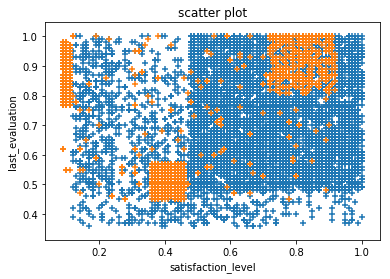

In [14]:
X_train0 = df[ df['left'] == 0]
X_train1 = df[ df['left'] == 1]

figure()

scatter(X_train0['satisfaction_level'],X_train0['last_evaluation'],marker='+' )
scatter(X_train1['satisfaction_level'],X_train1['last_evaluation'],marker='+')

xlabel('satisfaction_level')
ylabel('last_evaluation')
title('scatter plot')

show()

In [15]:
def findParentEntropy(df):
    if df.empty==True:
        return
    classCol=df.keys()[-1]
    #yeh sirf header return karega
    resultValues=df[classCol].unique()
    #all ouput values in output column
    entropy=0
    for value in resultValues:
        fraction=df[classCol].value_counts()[value]/(len(df[classCol])+eps)
        entropy+=-fraction*np.log2(fraction+eps)
    return abs(entropy)
    
    

def findRelativeEntropy(df,attribute):
    if df.empty==True:
        return
    classCol= df.keys()[-1] 
    #last col assumed as result 
    #getting target class 
    resultValues=df[classCol].unique() 
    attributeNames=df[attribute].unique()
    entropy2 = 0
    for attr in attributeNames:
        entropy = 0
        for value in resultValues:
            #temp&hot with yes
            num = len(df[attribute][df[attribute]==attr][df[classCol]==value])
            #total hot
            den = len(df[attribute][df[attribute]==attr])
            fraction = num/(den+eps)
            entropy += -fraction*np.log2(fraction+eps)
        #entropy attribute/total*(entropy attribute_values)
        fraction2 = den/len(df)  
        entropy2 += -fraction2*entropy 
    return abs(entropy2)

def get_subtable(df, node,value):
    return df[df[node] == value].reset_index(drop=True)


def get_subtableSmaller(df, node,value):
    if df.empty==True:
        return
    return df[df[node] < value].reset_index(drop=True)

def get_subtableGreater(df, node,value):
    if df.empty==True:
        return
    return df[df[node] >= value].reset_index(drop=True)

def bestAttribute(df):
    if df.empty==True:
        return
    infoGain=[]
    for key in df.keys()[:-1]:
        infoGain.append(findParentEntropy(df)-findRelativeEntropy(df,key))
    return df.keys()[:-1][np.argmax(infoGain)]
    



splitpoint={}
numeric=['last_evaluation','satisfaction_level','average_montly_hours','time_spend_company','number_project']
for col in numeric:
    df.sort_values(col,inplace=True)
    prev=None;
    value=0;
    max1=0;
    print(col)
    for index,row in df.iterrows():
        if prev is not None:
            if prev['left'] != row['left']:
                mid=(float(prev[col])+float(row[col]))/2
                subtableLeft=get_subtableSmaller(df,col,mid)
                subtableRight=get_subtableGreater(df,col,mid)
                fraction=len(subtableLeft)/len(df)
                fraction1=len(subtableRight)/len(df)
                entropy1=findParentEntropy(df)
#                 print(subtableLeft)
#                 a=input()
                firstSubtable=0
                secondSubtable=0
                if subtableLeft.empty:
                    firstSubtable=0
                else:
                    firstSubtable=fraction*findParentEntropy(subtableLeft)
#                 print(subtableRight)
                if subtableRight.empty:
                    secondSubtable=0
                else:
                    secondSubtable=fraction1*findParentEntropy(subtableRight)
                    
                entropy2=firstSubtable+secondSubtable
                ig1=abs(entropy1)-abs(entropy2)

                if ig1>max1:
                    max1=ig1
                    value=mid
        prev=row
    splitpoint[col]=value 
    for index,row1 in X_train.iterrows():
        if float(row1[col])<value:
            X_train.at[index,col]=0
        else:
            X_train.at[index,col]=1


# print(X_train)
# print(value)
# print(max1)
df=pd.concat([X_train,y_train],axis=1)
#df

class node:
    def __init__(self,value,left=None,right=None):
        self.value=value
        self.left=left
        self.right=right
        self.positive=0
        self.negative=0

def buildTree(df):
    if len(df.columns)==1:
        return
    
    resultLabel= df.keys()[-1] 
    clValue,counts = np.unique(df[resultLabel],return_counts=True)
    attribute_name=bestAttribute(df)
#     attValue = np.unique(df[attribute_name])
    root=node(attribute_name)
    
    if len(counts)<=1:
        if clValue[0]==0:
            root.negative=counts[0]
        else:
            root.positive=counts[0]
    else:
        root.positive=counts[1]
        root.negative=counts[0]
            
            
#         for value in attValue:
#             print(type(value))
        
        subtable0 = get_subtable(df,attribute_name,0)
        subtable0 =subtable0.drop([attribute_name],axis=1)
        subtable1 = get_subtable(df,attribute_name,1)
        subtable1 =subtable1.drop([attribute_name],axis=1)
        clValue,countleft = np.unique(subtable0[resultLabel],return_counts=True)
        clValue1,countright = np.unique(subtable1[resultLabel],return_counts=True)
        if(len(countleft)<=1):
            pass
        else:
            root.left=buildTree(subtable0) #Calling the function recursively
        if(len(countright)<=1):
            pass
        else:
            root.right=buildTree(subtable1)
       
                   
    return root

# print(df)
root=buildTree(df)
print(root.value)

print(root.right.value)
print(root.right.left)
print(root.left.value)
print(root.left.left.value)
print(root.left.right.value)
print(root.positive,root.negative)

def testing(row1,root):
#     if root==None:
#         return 
    #print(root.value)
    if root.left==None and root.right==None:
        if root.positive > root.negative:
            y1.append(1)
        else:
            y1.append(0)
        return
#     for i in row1.keys():
#         if i==root.value:
    i=root.value
    if row1[i]==0:
#         print("000")
        if root.left==None:
            if root.positive > root.negative:
                y1.append(1)
                return
            else:
                y1.append(0)
                return
        else:
            testing(row1,root.left)
    else:
#         print("111")
        if root.right==None:
            if root.positive > root.negative:
                y1.append(1)
                return
            else:
                y1.append(0)
                return 
        else:
            testing(row1,root.right)
                    
                

#X_test
print(splitpoint)

def testingData(df):
    for index,row in df.iterrows():
        testing(row,root)

y1=[] 
for col in numeric:
    value=splitpoint[col]
    for index,row1 in X_test.iterrows():
            if float(row1[col])<value:
                X_test.at[index,col]=0
            else:
                X_test.at[index,col]=1
X_test
testingData(X_test)  
print(len(y1))


print(confusion_matrix(y_test, y1))  
print(accuracy_score(y_test,y1))
print(classification_report(y_test, y1)) 

last_evaluation
satisfaction_level
average_montly_hours
time_spend_company
number_project
satisfaction_level
time_spend_company
number_project
last_evaluation
average_montly_hours
2147 6843
{'last_evaluation': 0.575, 'satisfaction_level': 0.46499999999999997, 'average_montly_hours': 287.5, 'time_spend_company': 3.0, 'number_project': 3.0}
2248
[[1654   66]
 [ 238  290]]
0.8647686832740213
              precision    recall  f1-score   support

           0       0.87      0.96      0.92      1720
           1       0.81      0.55      0.66       528

   micro avg       0.86      0.86      0.86      2248
   macro avg       0.84      0.76      0.79      2248
weighted avg       0.86      0.86      0.85      2248



In [16]:
classifier = DecisionTreeClassifier()
classifier.fit(orignalX, orignalY)  
y_pred = classifier.predict(testX)  
print(confusion_matrix(testY, y_pred))  
print(classification_report(testY, y_pred)) 
print(accuracy_score(testY,y_pred))

[[1685   35]
 [  28  500]]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1720
           1       0.93      0.95      0.94       528

   micro avg       0.97      0.97      0.97      2248
   macro avg       0.96      0.96      0.96      2248
weighted avg       0.97      0.97      0.97      2248

0.9719750889679716
